# 0.0 IMPORTS

In [106]:
import pandas as pd
import numpy as np
import re
from IPython.display import HTML, display
import warnings
from matplotlib import pyplot as plt
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly import express as px
import seaborn as sns
import umap.umap_ as umap

## 0.1 HELPER FUNCTIONS

In [2]:
def jupyter_settings():
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

jupyter_settings();
warnings.filterwarnings("ignore");

## 0.2 LOADING DATA 

In [3]:
df_raw = pd.read_pickle('dataset/df_raw.pkl')

# 1.0 DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1 DATA DIMENSIONS

In [5]:
print('Rows: {}'.format(df1.shape[0]))
print('Columns: {}'.format(df1.shape[1]))

Rows: 541909
Columns: 8


## 1.2 DATA TYPES

In [49]:
df1.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int32
Country                object
dtype: object

## 1.3 CHECKING NA DATA

In [7]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## 1.4 DROPING NA 

In [8]:
df1 = df1.dropna()

In [9]:
df1.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## 1.5 CHANGING TYPE 

In [10]:
df1['CustomerID'] = df1['CustomerID'].astype(int) 

## 1.6 DESCRIPTIVE STATISTICS 

In [47]:
num_attributes = df1.select_dtypes(include=['int64','int32','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.6.1 NUMERICAL ATTRIBUTES

In [41]:
#central tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
#dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T    

#concat
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T
m.columns = ['min','max','range','mean','median','std','skew','kurtosis']
m

,min,max,range,mean,median,std,skew,kurtosis
Quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
UnitPrice,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
CustomerID,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### 1.6.2 CATEGORICAL ATTRIBUTES

In [51]:
len(cat_attributes.loc[cat_attributes['InvoiceNo'].apply(lambda x: bool(re.search('[^0-9]+',str(x)))),'InvoiceNo'].drop_duplicates())

3654

In [55]:
cat_attributes.loc[cat_attributes['StockCode'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',str(x)))),'StockCode'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

# 2.0 VARIABLE FILTERING

In [56]:
df2 = df1.copy()

In [93]:
#numerical
df2 = df2[df2['UnitPrice']>0.01]
df2 = df2[~df2['StockCode'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK', 'C2'])]
df_returns = df2[df2['Quantity']<0]
df_purchase = df2[df2['Quantity']>0]

# 3.0 FEATURE ENGINEERING

In [97]:
df3 = df2.copy()
df3_purchase = df_purchase.copy()
df3_returns = df_returns.copy()

## 3.1 FEATURE CREATION

In [86]:
df3.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


### 3.1.1 GROSS REVENUE

In [87]:
df3['GrossRevenue'] = df3['Quantity'] * df3['UnitPrice']
df_m = df3[['CustomerID','GrossRevenue']].groupby('CustomerID').sum().reset_index()
df_m.head()

,CustomerID,GrossRevenue
0,12346,0.00
1,12347,4310.00
2,12348,1437.24
3,12349,1457.55
4,12350,294.40


### 3.1.2 RECENCY

In [88]:
df_r = df3_purchase[['CustomerID','InvoiceDate']].groupby('CustomerID').max().reset_index()
df_r['RecencyDays'] = (df3_purchase['InvoiceDate'].max()-df_r['InvoiceDate']).dt.days
df_r.drop('InvoiceDate',axis=1,inplace=True)
df_r.head()

,CustomerID,RecencyDays
0,12346,325
1,12347,1
2,12348,74
3,12349,18
4,12350,309


### 3.1.3 FREQUENCY

In [89]:
df_f = df3_purchase[['CustomerID','InvoiceNo']].drop_duplicates().groupby('CustomerID').count().reset_index()
df_f.head()

,CustomerID,InvoiceNo
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


### 3.1.4 AVERAGE TICKET

In [90]:
df_at=df3[['CustomerID','GrossRevenue']].groupby('CustomerID').mean().reset_index().rename(columns={'GrossRevenue':'AvgTicket'})
df_at.head()

,CustomerID,AvgTicket
0,12346,0.000000
1,12347,23.681319
2,12348,53.231111
3,12349,20.243750
4,12350,18.400000


### 3.1.5 NUMBER OF RETURNS

In [98]:
df3_returns = df3_returns[['CustomerID','InvoiceNo']].drop_duplicates().groupby('CustomerID').count().reset_index().rename(columns={'InvoiceNo':'Returns'})
df3_returns.head()

,CustomerID,Returns
0,12346,1
1,12352,1
2,12359,2
3,12362,3
4,12375,1


### 3.1.6 MERGING NEW FEATURES

In [113]:
df_ref = pd.merge(df_m,df_r,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_f,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_at,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df3_returns,on='CustomerID',how='left')
df_ref['Returns'] = df_ref['Returns'].fillna(value=0)
df_ref.head()

,CustomerID,GrossRevenue,RecencyDays,InvoiceNo,AvgTicket,Returns
0,12346,0.00,325.0,1.0,0.000000,1.0
1,12347,4310.00,1.0,7.0,23.681319,0.0
2,12348,1437.24,74.0,4.0,53.231111,0.0
3,12349,1457.55,18.0,1.0,20.243750,0.0
4,12350,294.40,309.0,1.0,18.400000,0.0


In [114]:
df_ref.isna().sum()

CustomerID       0
GrossRevenue     0
RecencyDays     27
InvoiceNo       27
AvgTicket        0
Returns          0
dtype: int64

# 4.0 EXPLORATORY DATA ANALYSIS

In [125]:
df4 = df_ref.dropna().copy()

# 5.0 DATA PREPARATION

In [126]:
df5 = df4.copy()

In [127]:
ss = pp.MinMaxScaler()
df5['GrossRevenue'] = ss.fit_transform(df5[['GrossRevenue']])
df5['RecencyDays'] = ss.fit_transform(df5[['RecencyDays']])
df5['InvoiceNo'] = ss.fit_transform(df5[['InvoiceNo']])
df5['AvgTicket'] = ss.fit_transform(df5[['AvgTicket']])
df5['Returns'] = ss.fit_transform(df5[['Returns']])

# 6.0 FEATURE SELECTION

In [128]:
df6 = df5.copy()

# 7.0 HYPERPARAMETER FINE TUNING

In [129]:
X = df6.drop(columns=['CustomerID'])
clusters = [2,3,4,5,6,7]
X.head()

,GrossRevenue,RecencyDays,InvoiceNo,AvgTicket,Returns
0,0.002850,0.871314,0.000000,0.005003,0.022222
1,0.018267,0.002681,0.029268,0.007382,0.000000
2,0.007991,0.198391,0.014634,0.010350,0.000000
3,0.008064,0.048257,0.000000,0.007037,0.000000
4,0.003903,0.828418,0.000000,0.006851,0.000000


## 7.1 WITHIN-CLUSTER SUM OF SQUARES (WSS)

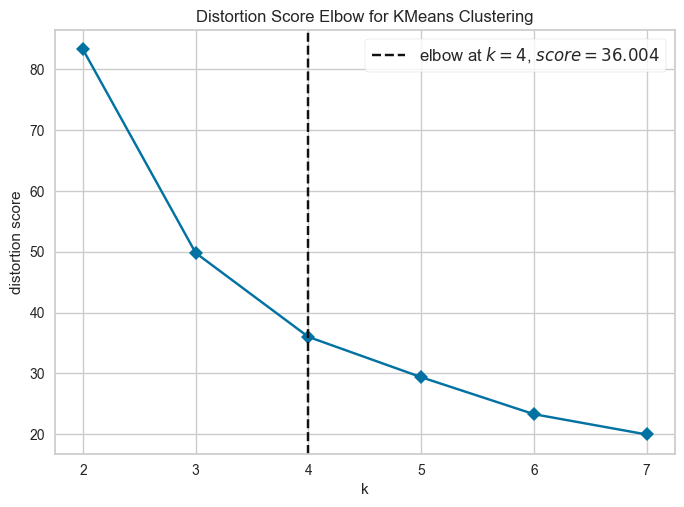

In [130]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 SILHOUETTE SCORE

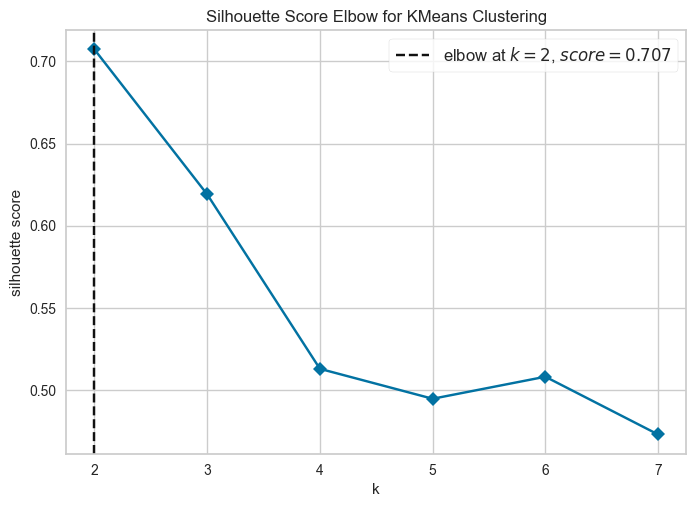

In [131]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters, metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show();

## 7.3 SILHOUETTE ANALYSIS

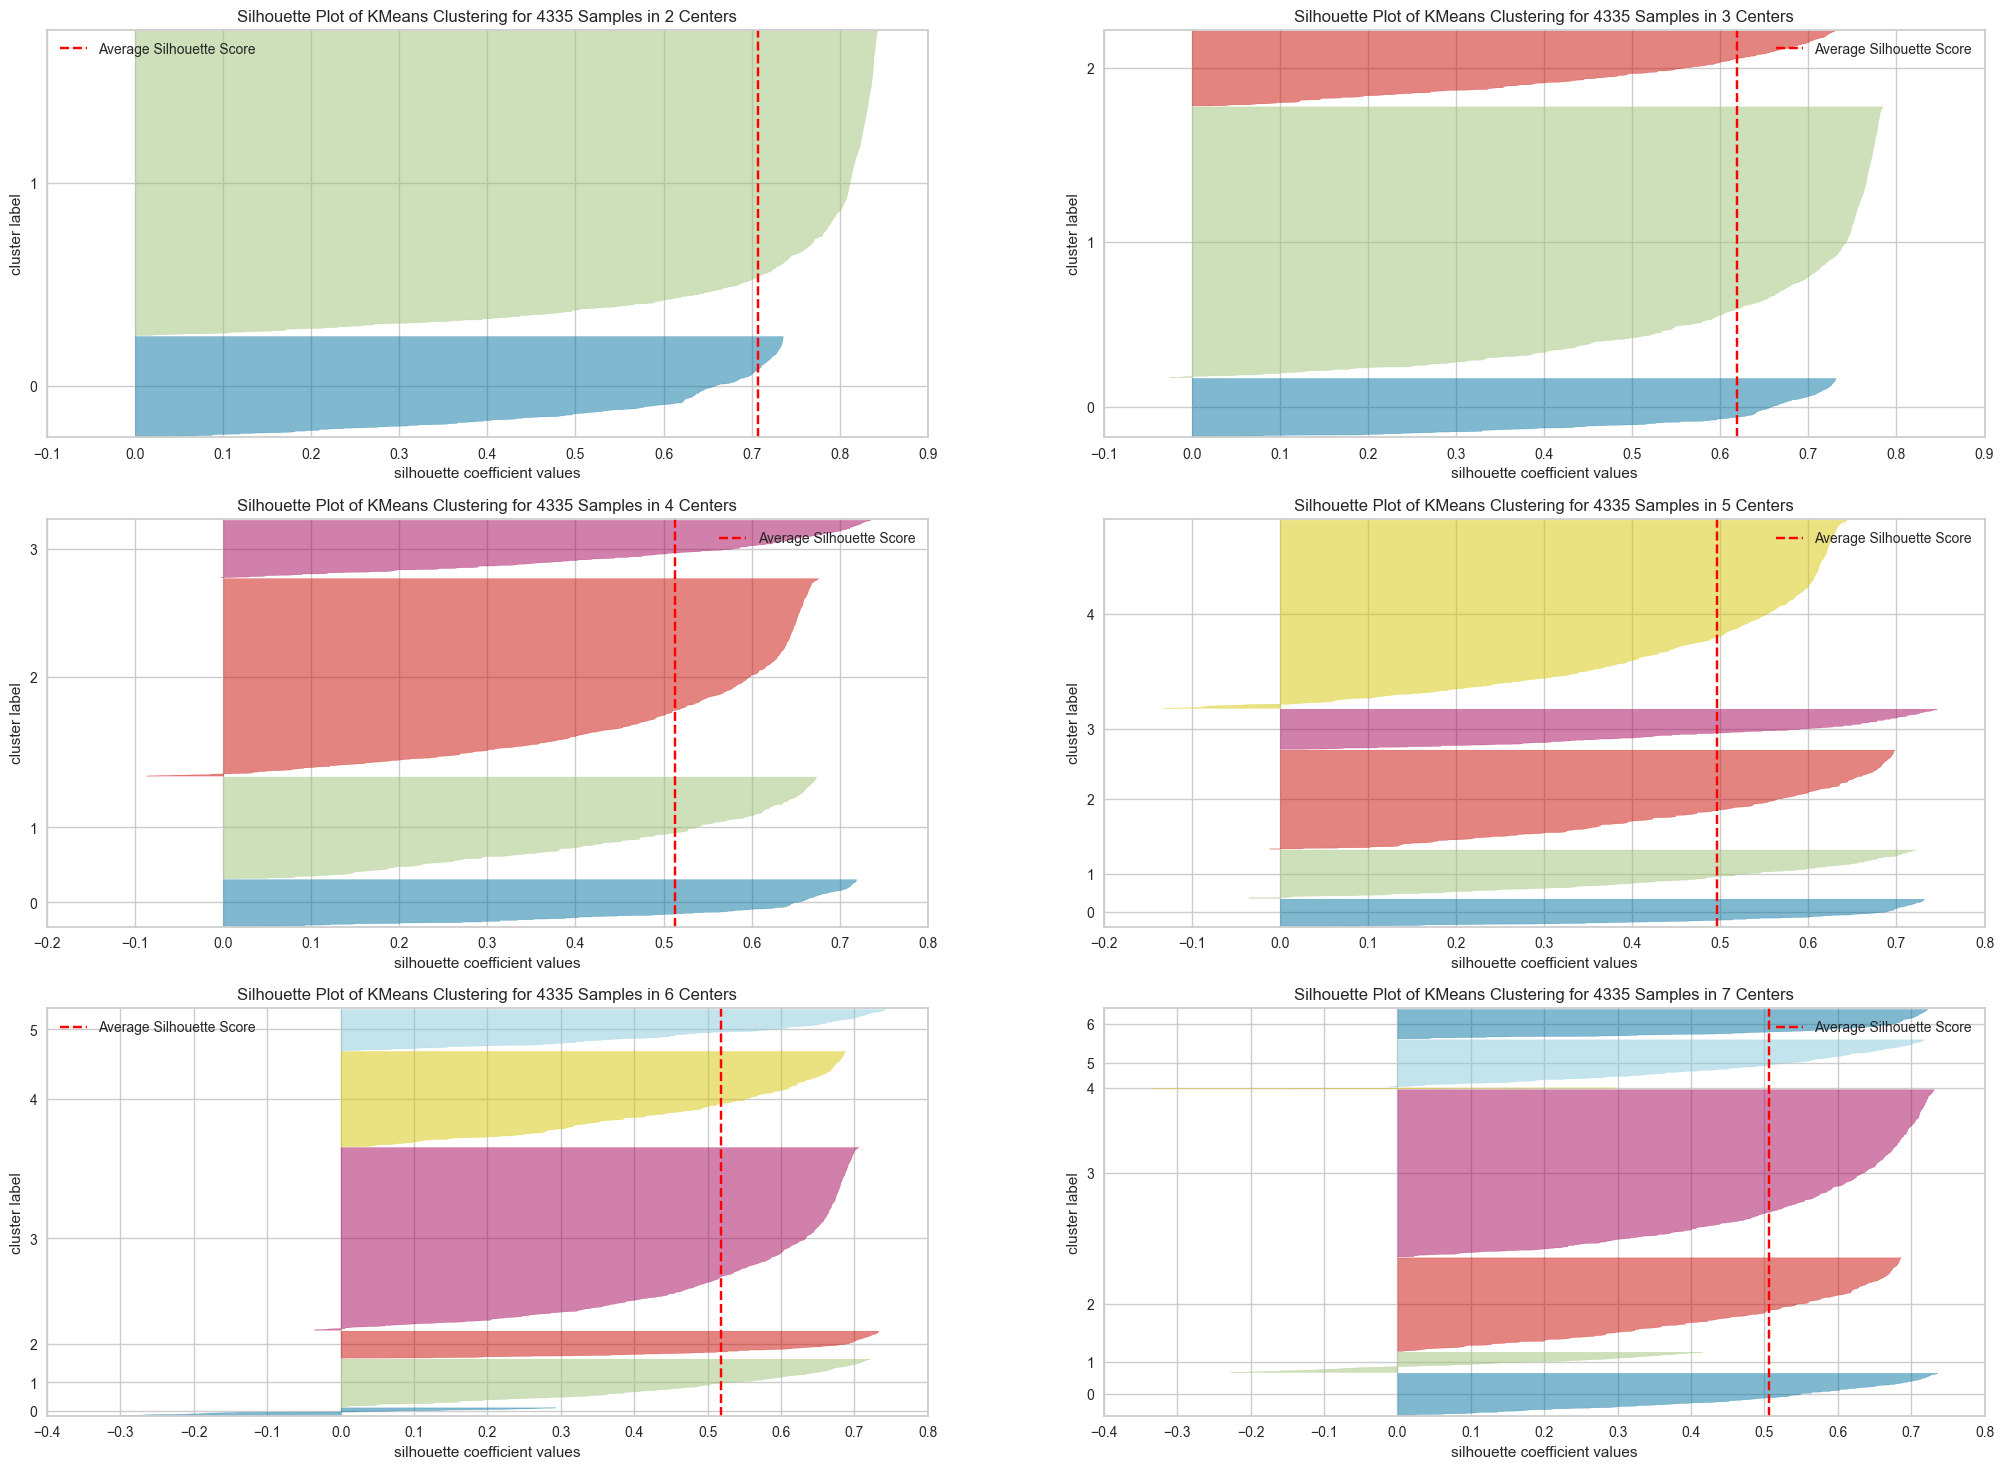

In [132]:
fig,ax = plt.subplots(3,2,figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k,init='random',n_init=10,max_iter=100,random_state=42)
    q, mod = divmod(k,2)    
    visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 MODEL TRAINING

In [133]:
k = 4
kmeans = c.KMeans(init='random',n_clusters=k,max_iter=300,random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

In [134]:
print('WSS value:{}'.format(kmeans.inertia_))
print('SS value:{}'.format(m.silhouette_score(X,labels,metric='euclidean')))

WSS value:36.00390293573624
SS value:0.5128734747367807


# 9.0 CLUSTER ANALYSIS

In [146]:
df9 = df4.copy()
df9['cluster'] = labels
df9.head()

,CustomerID,GrossRevenue,RecencyDays,InvoiceNo,AvgTicket,Returns,cluster
0,12346,0.00,325.0,1.0,0.000000,1.0,0
1,12347,4310.00,1.0,7.0,23.681319,0.0,2
2,12348,1437.24,74.0,4.0,53.231111,0.0,1
3,12349,1457.55,18.0,1.0,20.243750,0.0,2
4,12350,294.40,309.0,1.0,18.400000,0.0,0


## 9.1 VISUALIZATION INSPECTION

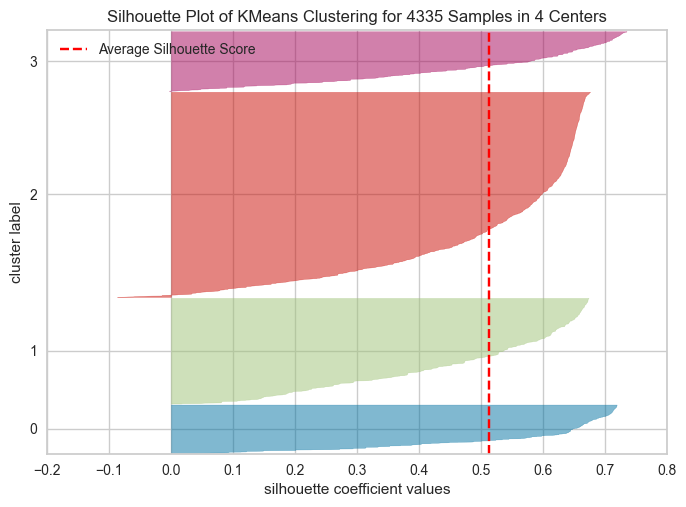

In [142]:
visualizer = SilhouetteVisualizer(kmeans,colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2D PLOT

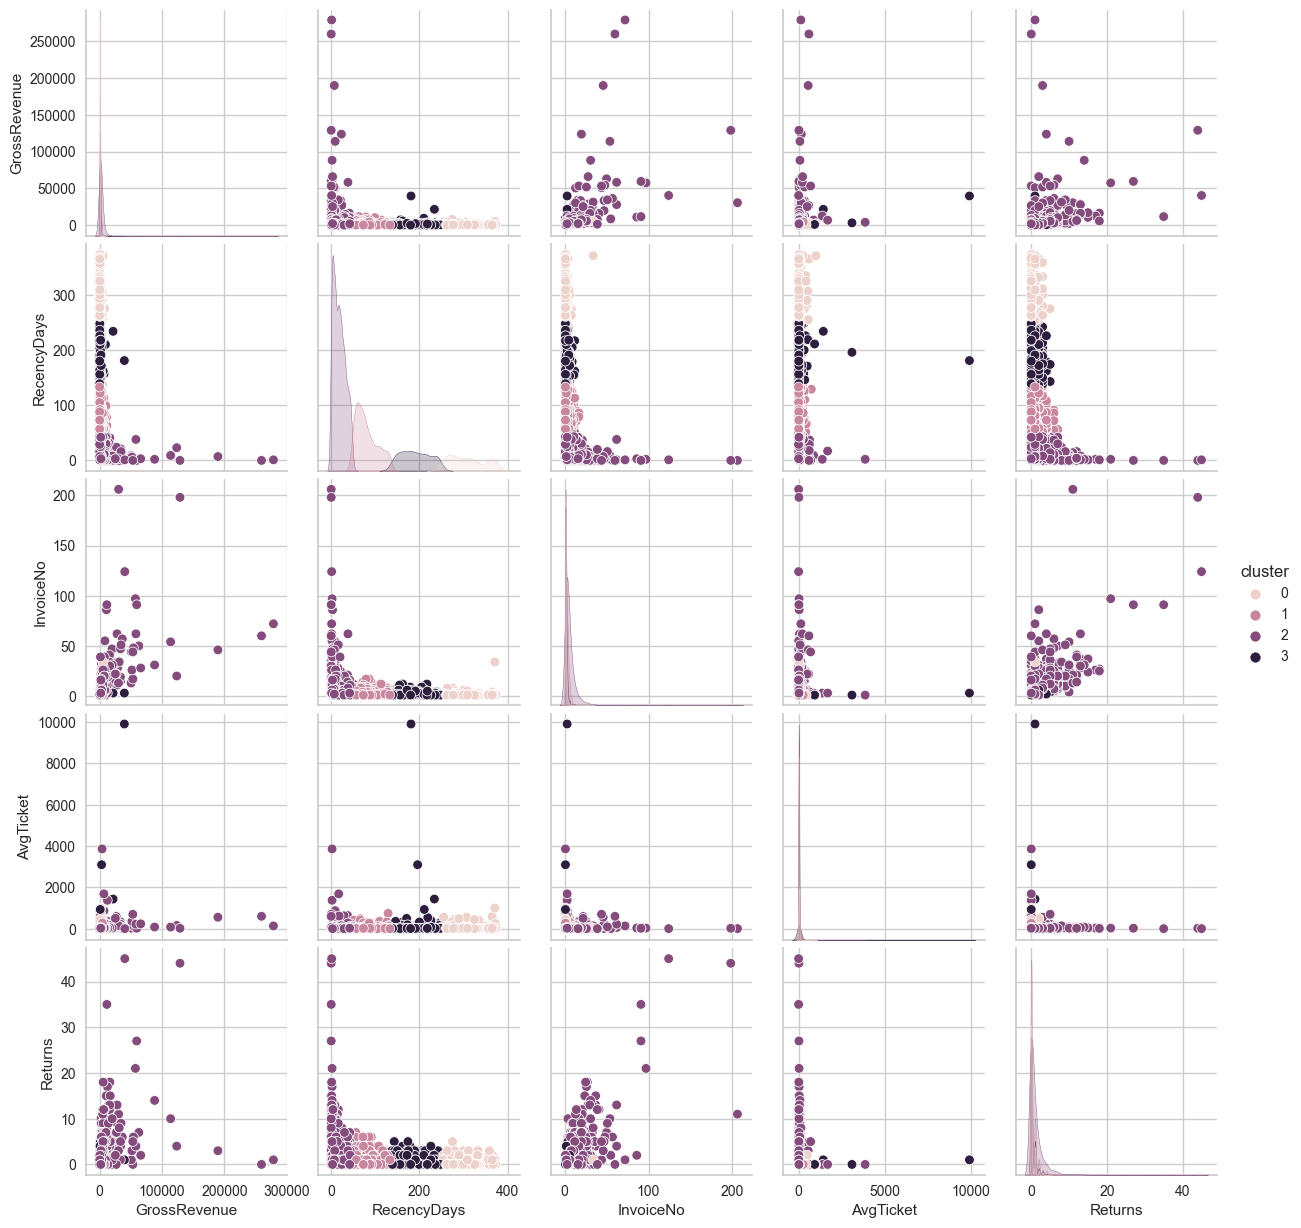

In [147]:
df_viz = df9.drop(columns=['CustomerID'])
sns.pairplot(df_viz,hue='cluster');

## 9.3 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

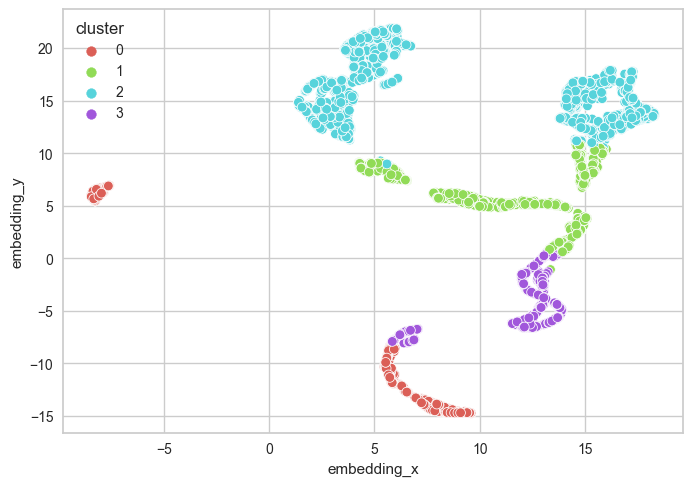

In [148]:
reducer = umap.UMAP(n_neighbors=30, random_state=42)
embedding = reducer.fit_transform(X)
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y',hue='cluster',palette=sns.color_palette('hls',n_colors=len(df_viz['cluster'].unique())), data=df_viz)

## 9.4 CLUSTER PROFILE

In [149]:
#Qty per cluster
df_cluster = df9[['CustomerID','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['CustomerID']/df_cluster['CustomerID'].sum())

#Avg gross rev
df_avg_grossrev = df9[['GrossRevenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_grossrev,how='inner',on='cluster')

#Avg recency days
df_avg_rec = df9[['RecencyDays','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_rec,how='inner',on='cluster')

#Avg invoice num
df_avg_invnum = df9[['InvoiceNo','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_invnum,how='inner',on='cluster')

#Avg ticket
df_avg_ticket = df9[['AvgTicket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_ticket,how='inner',on='cluster')

df_cluster.drop(columns=['CustomerID'])

,cluster,perc_customer,GrossRevenue,RecencyDays,InvoiceNo,AvgTicket
0,0,11.534025,394.235660,308.098000,1.342000,34.165844
1,1,25.236448,981.980740,79.825411,2.605119,29.826265
2,2,48.996540,3112.148390,18.146422,6.467514,29.536307
3,3,14.232987,661.801459,190.658023,1.871961,51.595869
